In [1]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()


Successfully saved authorization token.


In [2]:
# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive)
f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

In [3]:
import geopandas as gpd
shapefile = gpd.read_file("../data/external/Birmingham_Shapefile/LAD_DEC_2021_GB_BFC.shp")
shapefile.to_file('../data/processed/birmingham_shp.geojson', driver='GeoJSON')

c:\Users\lilia\Documents\GitHub\WMCA\DSSG_WMCA\.venv\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [4]:
u_poi = ee.Geometry.Point(shapefile.LONG[0], shapefile.LAT[0])

In [5]:
import json
with open('../data/processed/birmingham_shp.geojson') as f:
    shpfile = json.load(f)

birmingham = ee.FeatureCollection(shpfile)

In [6]:
scale = 1000

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

Average daytime LST at urban point: 18.8 °C


In [7]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()

# Preview the result.
lst_u_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2017_01_01',
  -1.8819705202303976,
  52.484070474683044,
  1483228800000,
  None,
  2],
 ['2017_01_02',
  -1.8819705202303976,
  52.484070474683044,
  1483315200000,
  13776,
  145],
 ['2017_01_03',
  -1.8819705202303976,
  52.484070474683044,
  1483401600000,
  None,
  2],
 ['2017_01_04',
  -1.8819705202303976,
  52.484070474683044,
  1483488000000,
  None,
  2]]

In [8]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [9]:
lst_df_urban = ee_array_to_df(lst_u_poi,['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)


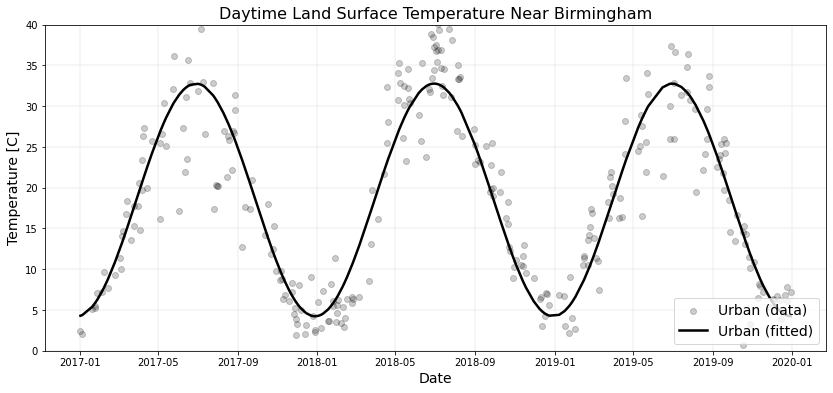

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  # urban

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))  # urban

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')

# Add fitting curves.
ax.plot(lst_df_urban['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Urban (fitted)', color='black', lw=2.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Near Birmingham', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

In [11]:
# Reduce the LST collection by mean.
lst_img = lst.mean()

# Adjust for scale factor.
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)

# Convert Kelvin to Celsius.
lst_img = lst_img.select('LST_Day_1km').add(-273.15)

In [22]:
# Define a region of interest with a buffer zone of 1000 km around Lyon.
# roi = birmingham.geometry()
roi = u_poi.buffer(30000)

In [127]:
from IPython.display import Image

# Create a URL to the styled image for a region around France.
url = lst_img.getThumbUrl({
    'min': 10, 'max': 25, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)

# Display the thumbnail land surface temperature in France.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)


https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1a8ec99c2c3ca43c6acdba9ad0aa62ae-3bd25675c5d22415cff340c9a42170e7:getPixels

Please wait while the thumbnail loads, it may take a moment...


In [23]:
lst_birmingham = lst_img.clip(birmingham)

# Create the URL associated with the styled image data.
url = lst_birmingham.getThumbUrl({
    'min': 10, 'max': 25, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)

# Display a thumbnail of elevation in France.
Image(url=url)


https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f14a619985e1d1b4c359da11384fd7bd-21d3c4aa711c7d7edb5b6ca4c1956b24:getPixels
